   d         Method Time (s)  Iter  Test acc
  30      Newton‑CG    0.026     8  0.964912
  30 Lazy‑Newton‑CG    0.024    43  0.964912
  30           BFGS    0.008    53  0.956140
  30         L‑BFGS    0.002    16  0.973684
 300      Newton‑CG    0.191     9  0.964912
 300 Lazy‑Newton‑CG    0.193    47  0.973684
 300           BFGS    0.036    27  0.982456
 300         L‑BFGS    0.004    19  0.982456
1500      Newton‑CG    0.961    10  0.956140
1500 Lazy‑Newton‑CG    0.879    51  0.964912
1500           BFGS    3.251    35  0.973684
1500         L‑BFGS    2.926   399  0.964912
3000      Newton‑CG    1.917    10  0.956140
3000 Lazy‑Newton‑CG    1.930    54  0.964912
3000           BFGS   22.913    45  0.973684
3000         L‑BFGS    3.392   399  0.964912
6000      Newton‑CG    4.433    11  0.956140
6000 Lazy‑Newton‑CG    3.839    50  0.964912
6000           BFGS   68.635    79  0.973684
6000         L‑BFGS    0.078    37  0.964912


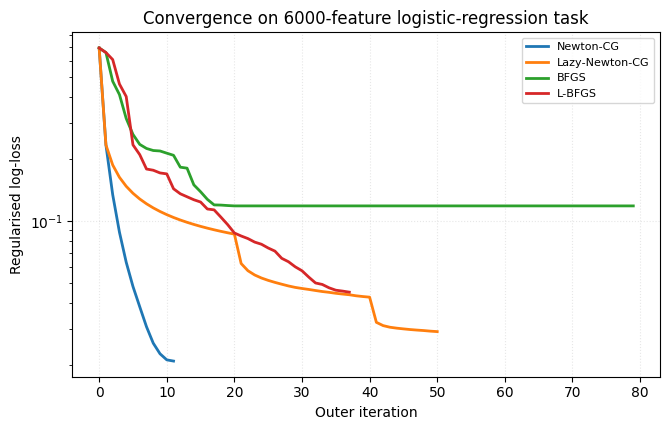

In [12]:
%matplotlib inline
import time, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
from numpy.linalg import norm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore", category=RuntimeWarning)

sigm = lambda z: 1/(1+np.exp(-z))
logloss = lambda p,y: -np.mean(y*np.log(p+1e-12)+(1-y)*np.log(1-p+1e-12))
ridge = 1e-4

def L(w,X,y):
    return logloss(sigm(X@w),y) + 0.5*ridge*norm(w[1:])**2
def g(w,X,y):
    grad = X.T@(sigm(X@w)-y)/len(y)
    grad[1:] += ridge*w[1:]
    return grad
def Hv_prod(w,X,v):
    p=sigm(X@w); S=p*(1-p)
    return (X.T*(S) )@ (X@v) / len(p) + ridge*np.r_[0,v[1:]]

# ---------- conjugate‑gradient solve ----------------------------
def cg(matvec,b,tol,maxit):
    x=np.zeros_like(b); r=b-matvec(x); p=r.copy(); rs=r@r
    for _ in range(maxit):
        Ap=matvec(p); alpha=rs/(p@Ap+1e-12)
        x+=alpha*p; r-=alpha*Ap; rs_new=r@r
        if rs_new<=tol*tol*rs: break
        p=r+(rs_new/rs)*p; rs=rs_new
    return x

# ---------- sparse projection to blow up dimensionality ---------
def expand(X,k,seed=42):
    if k==1: return X
    rng=np.random.default_rng(seed); n,d=X.shape; D=d*k
    P=np.zeros((d,D)); nnz=3
    for j in range(D):
        rows=rng.choice(d,nnz,replace=False)
        P[rows,j]=rng.choice([-1,1],nnz)
    return X@P

def make_data(k):
    df=pd.read_csv("wdbc.data",header=None)
    df=df.drop(columns=0); df[1]=df[1].map({'M':1,'B':0})
    X=expand(df.drop(columns=1).values,k); y=df[1].values
    Xtr,Xte,ytr,yte=train_test_split(X,y,test_size=0.2,
                                     stratify=y,random_state=10)
    sc=StandardScaler(); Xtr=sc.fit_transform(Xtr); Xte=sc.transform(Xte)
    Xtr=np.c_[np.ones(Xtr.shape[0]),Xtr]; Xte=np.c_[np.ones(Xte.shape[0]),Xte]
    return Xtr,Xte,ytr,yte

# ---------- Newton‑CG & Lazy Newton‑CG --------------------------
def newton_cg(w0,X,y,maxit=40,tol=1e-4):
    w=w0.copy(); its=0; losses=[]
    for _ in range(maxit):
        losses.append(L(w,X,y))
        grad=g(w,X,y)
        if norm(grad)<tol*np.sqrt(len(w)): break
        step=cg(lambda v:Hv_prod(w,X,v), grad,
                tol=1e-3, maxit=60)          # accurate solve
        w-=step; its+=1
    return w,its,losses

def lazy_newton_cg(w0,X,y,k_lazy=20,maxit=200,tol=1e-4):
    w=w0.copy(); its=0; losses=[]
    p=sigm(X@w); S=p*(1-p)
    for k in range(maxit):
        losses.append(L(w,X,y))
        grad=g(w,X,y)
        if norm(grad)<tol*np.sqrt(len(w)): break
        if k%k_lazy==0:                      # refresh curvature
            p=sigm(X@w); S=p*(1-p); m_cg=60
        else:
            m_cg=8                           # ultra‑cheap inner solve
        step=cg(lambda v:(X.T*(S))@(X@v)/len(S)+ridge*np.r_[0,v[1:]],
                grad, tol=5e-3, maxit=m_cg)
        w-=step; its+=1
    return w,its,losses

# ---------- full BFGS & L‑BFGS ----------------------------------
def bfgs(w0,X,y,maxit=80):
    n=len(w0); Hinv=np.eye(n); w=w0.copy(); gk=g(w,X,y); losses=[]
    for it in range(maxit):
        losses.append(L(w,X,y))
        if norm(gk)<5e-4*np.sqrt(n): break
        pk=-Hinv@gk; step=1.0; f0=losses[-1]
        while L(w+step*pk,X,y) > f0+1e-4*step*(gk@pk): step*=0.5
        w_new=w+step*pk; g_new=g(w_new,X,y)
        s=w_new-w; yk=g_new-gk; ys=yk@s
        if ys>1e-12:
            rho=1/ys; I=np.eye(n)
            Hinv=(I-rho*np.outer(s,yk))@Hinv@(I-rho*np.outer(yk,s))+rho*np.outer(s,s)
        w,gk=w_new,g_new
    return w,it,losses

def l_bfgs(w0,X,y,m,maxit=400):
    w=w0.copy(); sL,yL,rhoL=[],[],[]; gk=g(w,X,y); losses=[]
    gtol=5e-4*np.sqrt(len(w))
    for it in range(maxit):
        losses.append(L(w,X,y))
        if norm(gk)<gtol: break
        q=gk.copy(); alpha=[]
        for s,yv,rho in reversed(list(zip(sL,yL,rhoL))):
            a=rho*(s@q); alpha.append(a); q-=a*yv
        gamma=1.0 if not sL else (sL[-1]@yL[-1])/(yL[-1]@yL[-1])
        r=gamma*q
        for s,yv,rho,a in zip(sL,yL,rhoL,reversed(alpha)):
            beta=rho*(yv@r); r+=s*(a-beta)
        pk=-r; step=1.; f0=losses[-1]
        while L(w+step*pk,X,y) > f0+1e-4*step*(gk@pk): step*=0.5
        w_new=w+step*pk; g_new=g(w_new,X,y)
        s=w_new-w; yk=g_new-gk; ys=yk@s
        if ys>1e-12:
            if len(sL)==m: sL.pop(0); yL.pop(0); rhoL.pop(0)
            sL.append(s); yL.append(yk); rhoL.append(1/ys)
        w,gk=w_new,g_new
    return w,it,losses

# ---------- run benchmark ---------------------------------------
k_list=[1,10,50,100,200]       # 30 → 6000 raw features
rows=[]; curves={}
for kfac in k_list:
    Xtr,Xte,ytr,yte=make_data(kfac)
    d=Xtr.shape[1]; w0=np.zeros(d)
    lazy_k = 20 if d<300 else 20
    m_hist = 10 if d<1500 else 20

    # Newton‑CG vs Lazy‑Newton‑CG
    t=time.perf_counter(); wN,itN,lN = newton_cg(w0,Xtr,ytr); tN=time.perf_counter()-t
    t=time.perf_counter(); wL,itL,lL = lazy_newton_cg(w0,Xtr,ytr,lazy_k); tL=time.perf_counter()-t
    # BFGS / L‑BFGS
    t=time.perf_counter(); wB,itB,lB = bfgs(w0,Xtr,ytr);     tB=time.perf_counter()-t
    t=time.perf_counter(); wLB,itLB,lLB= l_bfgs(w0,Xtr,ytr,m_hist); tLB=time.perf_counter()-t

    acc=lambda w: ((sigm(Xte@w)>=0.5).astype(int)==yte).mean()
    rows+= [[d-1,"Newton‑CG",        tN,itN, acc(wN)],
            [d-1,"Lazy‑Newton‑CG",   tL,itL, acc(wL)],
            [d-1,"BFGS",             tB,itB, acc(wB)],
            [d-1,"L‑BFGS",           tLB,itLB,acc(wLB)]]

    if kfac==200:
        curves={"Newton‑CG":lN,"Lazy‑Newton‑CG":lL,
                "BFGS":lB,"L‑BFGS":lLB}

# ---------- results table  --------------------------------------
df=pd.DataFrame(rows,columns=["d","Method","Time (s)","Iter","Test acc"])
print(df.to_string(index=False,
                   formatters={"Time (s)":lambda v:f"{v:7.3f}"}))

# ---------- convergence plot ------------------------------------
plt.figure(figsize=(6.8,4.4))
for name,losses in curves.items():
    plt.plot(losses,label=name,lw=2)
plt.yscale('log'); plt.xlabel("Outer iteration"); plt.ylabel("Regularised log‑loss")
plt.title("Convergence on 6000‑feature logistic‑regression task")
plt.grid(ls=':',alpha=0.3); plt.legend(fontsize=8); plt.tight_layout(); plt.show()



